# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 1:
    * Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* inputs/brain-tumor-mri-dataset/mri-images/train
* inputs/brain-tumor-mri-dataset/mri-images/test
* inputs/brain-tumor-mri-dataset/mri-images/validation

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments


---

## Import the regular packages

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-10-30 17:16:45.622966: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 17:16:45.662977: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/brain-tumor-detector/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/brain-tumor-detector'

## Set input directories
Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/brain-tumor-mri-dataset/mri-images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

# Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(150, 150, 3)

---

### Number of images in train, test and validation data

* train - glioma: 1134 images
* train - meningioma: 1151 images
* train - notumor: 1400 images
* train - pituitary: 1229 images
* validation - glioma: 162 images
* validation - meningioma: 164 images
* validation - notumor: 200 images
* validation - pituitary: 175 images
* test - glioma: 325 images
* test - meningioma: 330 images
* test - notumor: 400 images
* test - pituitary: 353 images




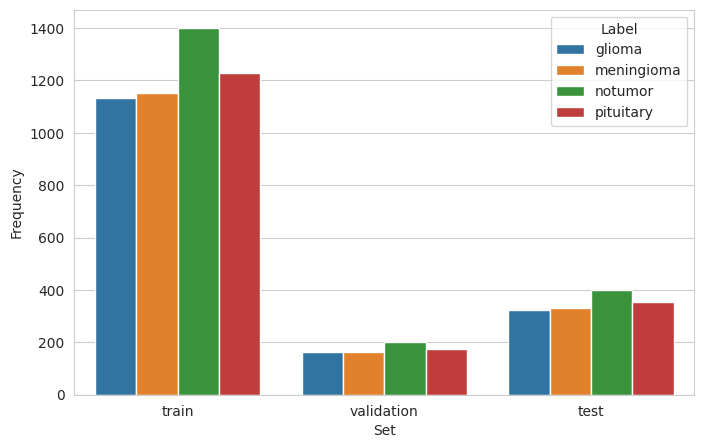

In [9]:
df_freq = pd.DataFrame([])
data_list = []

for folder in ['train', 'validation', 'test']:
    for label in labels:
        # Collect data in a list of dictionaries
        data_list.append({
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        })

        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images")

# Convert list of dictionaries to a DataFrame
df_freq = pd.DataFrame(data_list)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


---

## Image data augmentation

Global Variables and Random Seeds

In [10]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)


Initialize ImageDataGenerator

In [11]:
# Data augmentation and preprocessing
augmented_image_data = ImageDataGenerator(
                                        rescale=1./255,
                                        rotation_range=30,
                                        brightness_range=(0.8, 1.2),
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=15,
                                        zoom_range=0.1,
                                        channel_shift_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode="nearest")


Augment training image dataset

In [13]:
# applying the generator to training data with constant seed
batch_size = 32
train_set = augmented_image_data.flow_from_directory(
                                                    train_path,
                                                    batch_size=batch_size,
                                                    target_size=image_shape[:2],
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=SEED)
train_set.class_indices

Found 4914 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Augment validation image dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        batch_size=batch_size,
                                                                        target_size=image_shape[:2],
                                                                        class_mode='categorical',
                                                                        shuffle=False,
                                                                        seed=SEED)

validation_set.class_indices

Found 701 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Augment test image dataset

In [15]:
# applying the generator to testing data with constant seed
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  batch_size=batch_size,
                                                                  target_size=image_shape[:2],
                                                                  class_mode='categorical',
                                                                  shuffle=False,
                                                                  seed=SEED)

test_set.class_indices

Found 1408 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Plot augmented training image

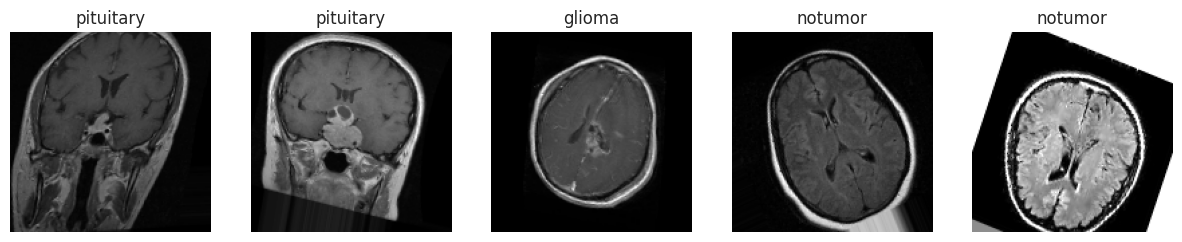

In [16]:
# Get a batch of images from the generator
x_batch, y_batch = next(train_set)  # Extract the first batch of augmented images

# Display the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(list(train_set.class_indices.keys())[np.argmax(y_batch[i])])  # Display the class name
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()



Plot augmented validation images

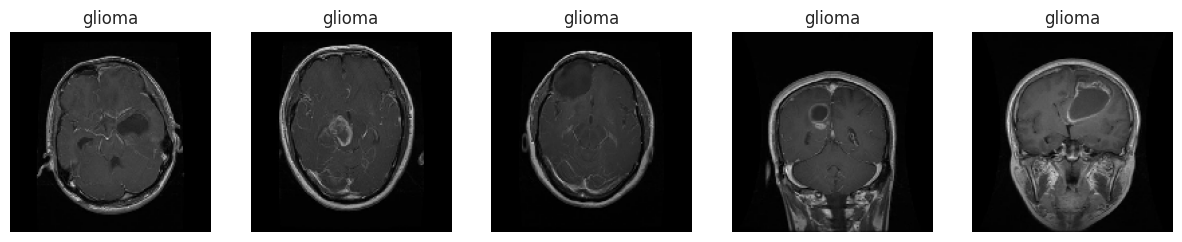

In [17]:
# Get a batch of images from the generator
x_batch, y_batch = next(validation_set)  # Extract the first batch of augmented images

# Display the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(list(validation_set.class_indices.keys())[np.argmax(y_batch[i])])
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()


Plot augmented test images

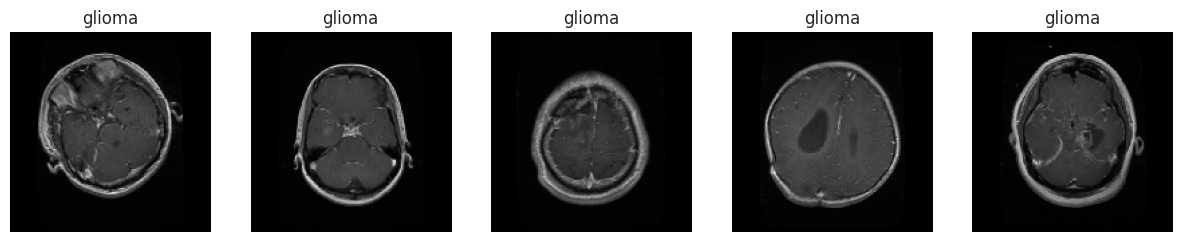

In [18]:
# Get a batch of images from the generator
x_batch, y_batch = next(test_set)  # Extract the first batch of augmented images

# Display the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(list(test_set.class_indices.keys())[np.argmax(y_batch[i])])
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()


### Save class_indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model creation

### ML model
Import model packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, BatchNormalization

Model

In [23]:
def create_tf_model():
    """
    Creates and compiles a convolutional neural network model.

    Parameters:
    - image_shape: Tuple indicating the shape of input images (height, width, channels).
    - N_TYPES: The number of output classes.
    - SEED: Random seed for dropout layer.

    Returns:
    - model: A compiled TensorFlow Keras model.
    """
    model = Sequential()
    model.add(Input(shape=image_shape))

    # Conv layer 1
    model.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Conv layer 2
    model.add(Conv2D(64, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Conv layer 3
    model.add(Conv2D(128, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Conv layer 4
    model.add(Conv2D(128, (4, 4), activation="relu"))
    model.add(Flatten())

    # Full connect layers
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5, seed=SEED))
    model.add(Dense(N_TYPES, activation="softmax"))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
    
    return model

In [24]:
# Call the function and display the model summary
model = create_tf_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

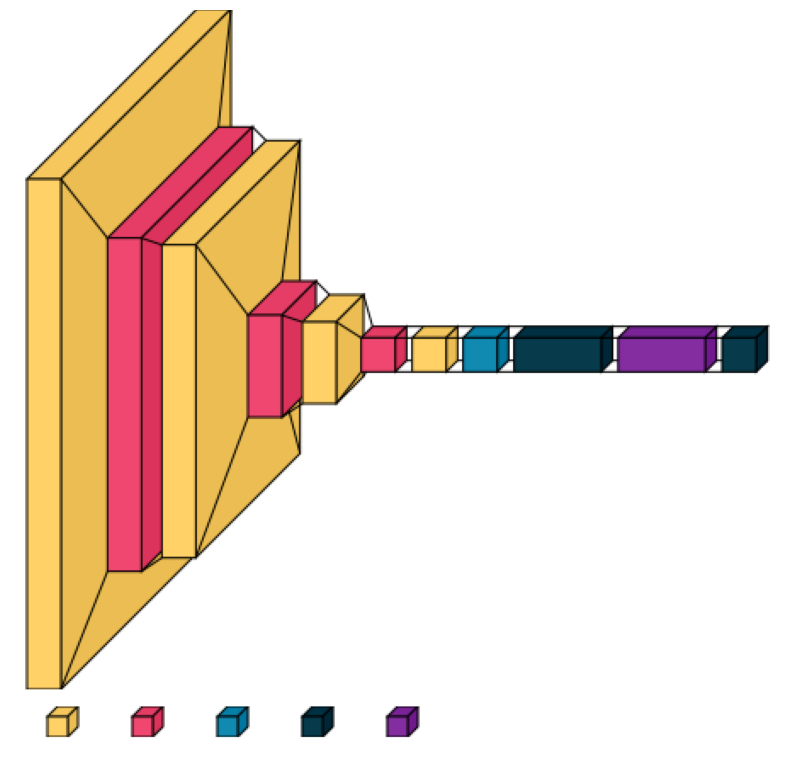

In [26]:
import visualkeras

# Visualize the model
model_str = visualkeras.layered_view(model, legend=True, max_xy=300, legend_text_spacing_offset=10)

plt.figure(figsize=(10, 10))
plt.imshow(model_str)
plt.axis('off')

plt.savefig(f'{file_path}/model_visualization.png', bbox_inches='tight', dpi=150)

plt.show()

plt.close()

Early Stopping

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training if loss doesn't keep decreasing.
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=8, restore_best_weights=True, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Increase steps_per_epoch to repeat the dataset more times per epoch
steps_per_epoch = (len(train_set.classes) // batch_size) * 3  # Repeat dataset 3 times per epoch (adjust multiplier as needed)

Fit model for model training

In [28]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=steps_per_epoch,
          validation_data=validation_set,
          callbacks=[early_stop, model_rlr])

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
154/459 ━━━━━━━━━━━━━━━━━━━━ 1:40 329ms/step - accuracy: 0.3836 - loss: 1.2115

2024-10-28 20:35:42.053925: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


459/459 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.4649 - loss: 1.0982 - val_accuracy: 0.6904 - val_loss: 0.7552 - learning_rate: 0.0010
Epoch 2/25
154/459 ━━━━━━━━━━━━━━━━━━━━ 1:36 318ms/step - accuracy: 0.6743 - loss: 0.7678

2024-10-28 20:36:33.154276: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


459/459 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.6841 - loss: 0.7505 - val_accuracy: 0.7589 - val_loss: 0.5845 - learning_rate: 0.0010
Epoch 3/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 54s 117ms/step - accuracy: 0.7378 - loss: 0.6310 - val_accuracy: 0.8060 - val_loss: 0.5072 - learning_rate: 0.0010
Epoch 4/25
154/459 ━━━━━━━━━━━━━━━━━━━━ 1:39 325ms/step - accuracy: 0.7809 - loss: 0.5616

2024-10-28 20:38:19.253904: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


459/459 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.7806 - loss: 0.5547 - val_accuracy: 0.8046 - val_loss: 0.5068 - learning_rate: 0.0010
Epoch 5/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 52s 112ms/step - accuracy: 0.7917 - loss: 0.5099 - val_accuracy: 0.8516 - val_loss: 0.4135 - learning_rate: 0.0010
Epoch 6/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - accuracy: 0.8129 - loss: 0.4653 - val_accuracy: 0.8616 - val_loss: 0.3795 - learning_rate: 0.0010
Epoch 7/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - accuracy: 0.8369 - loss: 0.4183 - val_accuracy: 0.8673 - val_loss: 0.3718 - learning_rate: 0.0010
Epoch 8/25
154/459 ━━━━━━━━━━━━━━━━━━━━ 1:42 336ms/step - accuracy: 0.8519 - loss: 0.3681

2024-10-28 20:41:46.952336: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


459/459 ━━━━━━━━━━━━━━━━━━━━ 54s 117ms/step - accuracy: 0.8588 - loss: 0.3593 - val_accuracy: 0.8787 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 9/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 52s 112ms/step - accuracy: 0.8754 - loss: 0.3297 - val_accuracy: 0.9087 - val_loss: 0.2566 - learning_rate: 0.0010
Epoch 10/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 62s 134ms/step - accuracy: 0.8948 - loss: 0.2833 - val_accuracy: 0.8759 - val_loss: 0.3180 - learning_rate: 0.0010
Epoch 11/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 63s 138ms/step - accuracy: 0.9023 - loss: 0.2491 - val_accuracy: 0.8944 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 12/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 58s 126ms/step - accuracy: 0.9148 - loss: 0.2346 - val_accuracy: 0.9201 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 13/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - accuracy: 0.9118 - loss: 0.2336 - val_accuracy: 0.9215 - val_loss: 0.2288 - learning_rate: 0.0010
Epoch 14/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 57s 123ms/step - accuracy: 0.9213 - 

2024-10-28 20:49:12.454220: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


459/459 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.9307 - loss: 0.1889 - val_accuracy: 0.8902 - val_loss: 0.3514 - learning_rate: 0.0010
Epoch 17/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 52s 112ms/step - accuracy: 0.9344 - loss: 0.1824 - val_accuracy: 0.9344 - val_loss: 0.1723 - learning_rate: 0.0010
Epoch 18/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.9352 - loss: 0.1809 - val_accuracy: 0.9330 - val_loss: 0.2200 - learning_rate: 0.0010
Epoch 19/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 58s 125ms/step - accuracy: 0.9435 - loss: 0.1542 - val_accuracy: 0.9201 - val_loss: 0.2255 - learning_rate: 0.0010
Epoch 20/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.9434 - loss: 0.1657 - val_accuracy: 0.9429 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 21/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.9380 - loss: 0.1604 - val_accuracy: 0.9458 - val_loss: 0.1791 - learning_rate: 0.0010
Epoch 22/25
459/459 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.9463 -

saving the


In [31]:
model.save('outputs/v1/brain_tumor_detector.keras')


## Model Performace

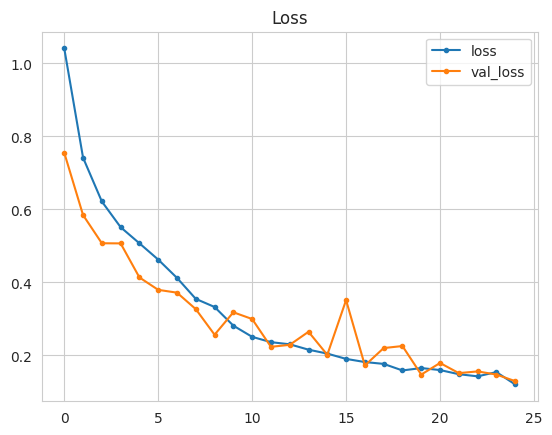

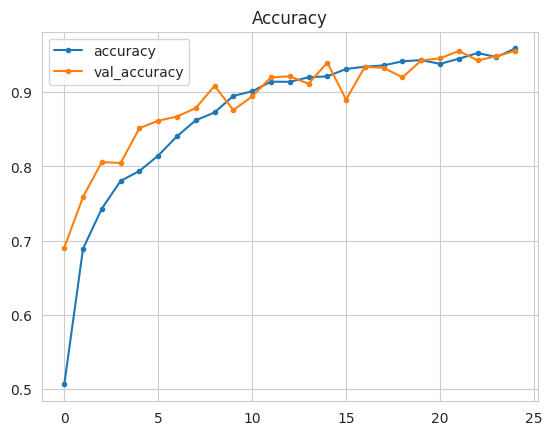

In [30]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation
Load saved model

In [32]:
from tensorflow.keras.models import load_model

# Reload the model to ensure fresh state
model = load_model('outputs/v1/brain_tumor_detector.keras')

Evaluate model on test set

In [33]:
# Evaluating the model
loss, accuracy = model.evaluate(test_set, steps=test_set.samples // batch_size)
print(f"Test Loss: {loss:.5f}")
print(f"Test Accuracy: {accuracy:.5f}")

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9635 - loss: 0.1084
Test Loss: 0.11078
Test Accuracy: 0.96307


Save evaluation pickle

In [34]:
# Saving the evaluation results in a dictionary
evaluation = {
    'loss': loss,
    'accuracy': accuracy
}

# Saving the evaluation results using joblib
joblib.dump(value=evaluation, filename="outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data
Load a random image as PIL

Load a random image as PIL

Image shape: (150, 150), Image mode: RGB


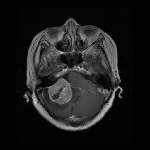

In [42]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [43]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 150, 150, 3)


Predict class probabilities

In [44]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.860013
meningioma


## confusion matrix

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step


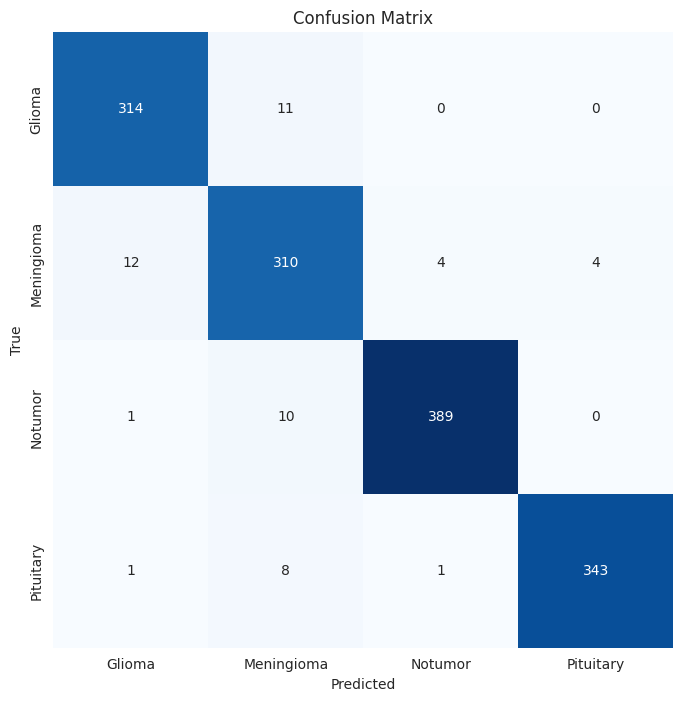

In [45]:
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

# Make predictions on the test set
predictions = model.predict(test_set, steps=test_set.samples // batch_size)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes from test set
true_classes = test_set.classes

# Get class names
class_indices_train_list = list(train_set.class_indices.keys())

# Compute confusion matrix
cm = sklearn_confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(class_indices_train_list)) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(len(class_indices_train_list)) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')

plt.savefig('outputs/v1/confusion_matrix.png', bbox_inches='tight', dpi=150)

plt.show()



---


## Conclusion

This notebook is for modeling and evaluation of a brain tumor detector . It covers data preprocessing, model creation, training, evaluation, prediction, and confusion matrix generation. The script also includes data augmentation, early stopping, and learning rate reduction to improve the model's performance.